# Libraries and installations

In [1]:
from google.colab import drive
drive.mount('/content/drive')
PROJECT_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/Neuroimaging course/Project'
%cd {PROJECT_DIRECTORY}

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Neuroimaging course/Project


In [2]:
# !git clone https://github.com/roseDwayane/AIEEG
!pip install mne -q
!pip install pymatreader -q
!pip install ipympl -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import torch as t
from matplotlib import pyplot as plt
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

# Walking dataset

In [4]:
WALKING_DATA_DIR = './Walking Experiment/'
running_original_raw = mne.io.read_raw_eeglab(WALKING_DATA_DIR + 'setfile/running_original.set', uint16_codec='latin-1', preload=True)
running_denoised_raw = mne.io.read_raw_eeglab(WALKING_DATA_DIR + 'denoise_set/running_denoise.set', uint16_codec='latin-1', preload=True)

Reading /content/drive/MyDrive/Colab Notebooks/Neuroimaging course/Project/Walking Experiment/setfile/running_original.fdt
Reading 0 ... 260635  =      0.000 ...  1018.105 secs...


<ipython-input-4-84ab33ed26ed>:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  running_original_raw = mne.io.read_raw_eeglab(WALKING_DATA_DIR + 'setfile/running_original.set', uint16_codec='latin-1', preload=True)


Reading /content/drive/MyDrive/Colab Notebooks/Neuroimaging course/Project/Walking Experiment/denoise_set/running_denoise.fdt
Reading 0 ... 260095  =      0.000 ...  1015.996 secs...


<ipython-input-4-84ab33ed26ed>:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  running_denoised_raw = mne.io.read_raw_eeglab(WALKING_DATA_DIR + 'denoise_set/running_denoise.set', uint16_codec='latin-1', preload=True)


In [ ]:
running_original_raw

<RawEEGLAB | running_original.fdt, 30 x 260636 (1018.1 s), ~46 kB, data not loaded>

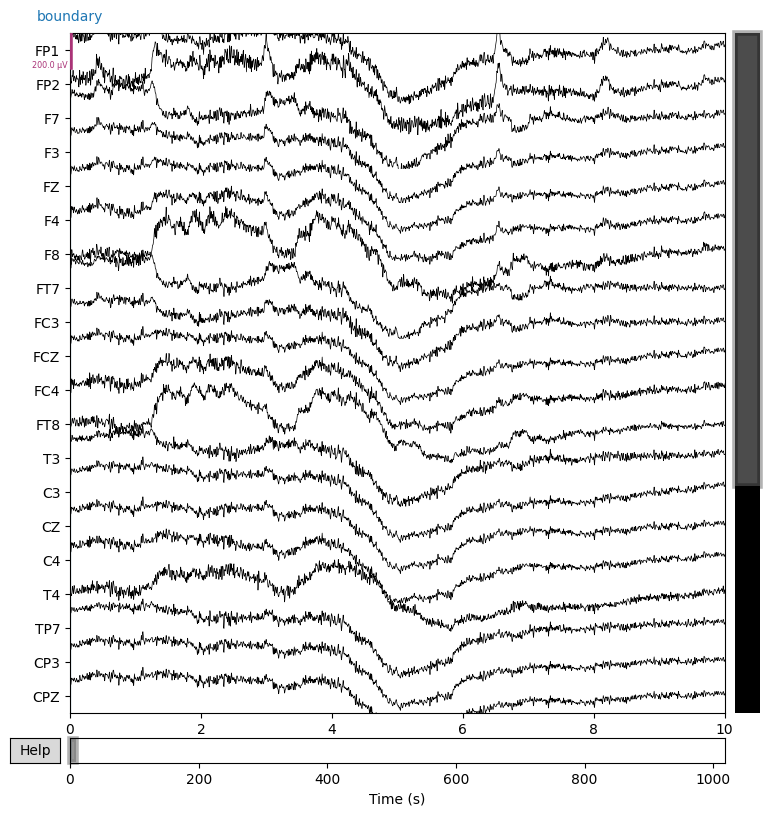

In [ ]:
running_original_raw.plot(duration=10, scalings=100e-6);

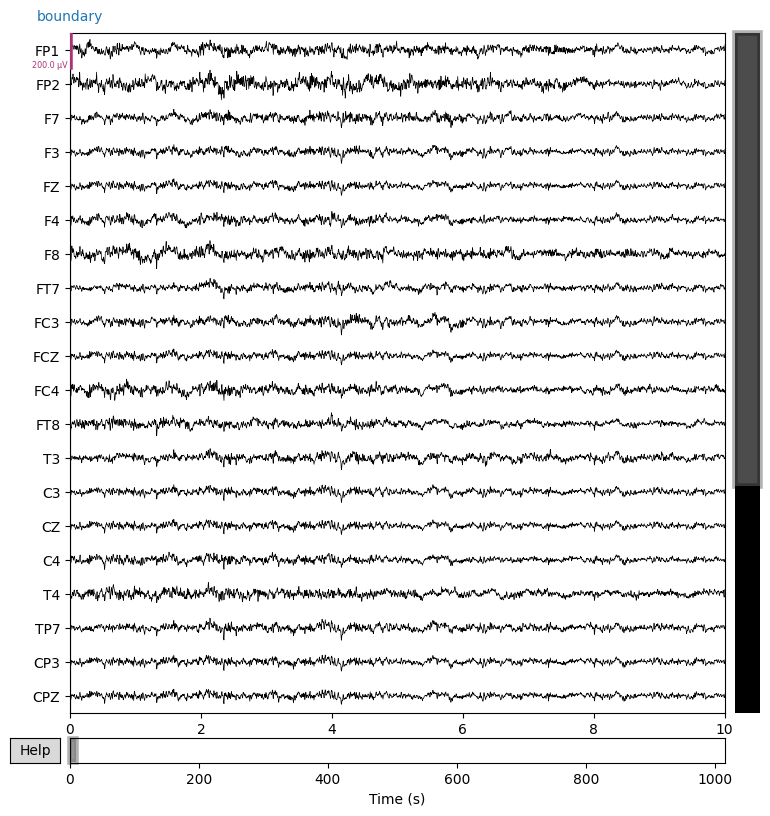

In [ ]:
running_denoised_raw.plot(duration=10, scalings=100e-6);

Effective window size : 8.000 (s)


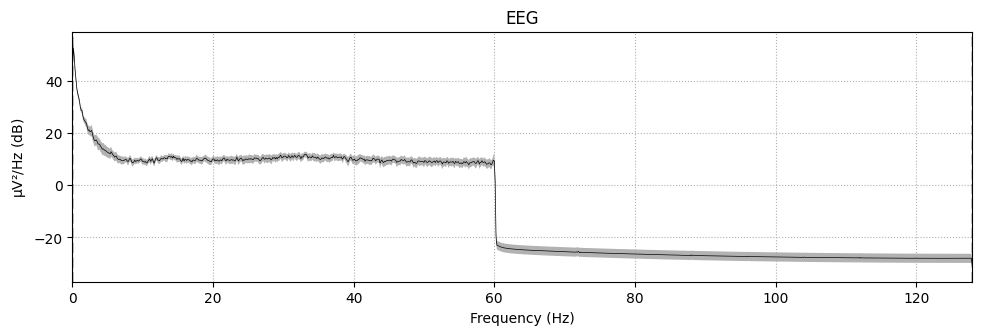

In [ ]:
spectrum = running_original_raw.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads", );

Effective window size : 8.000 (s)


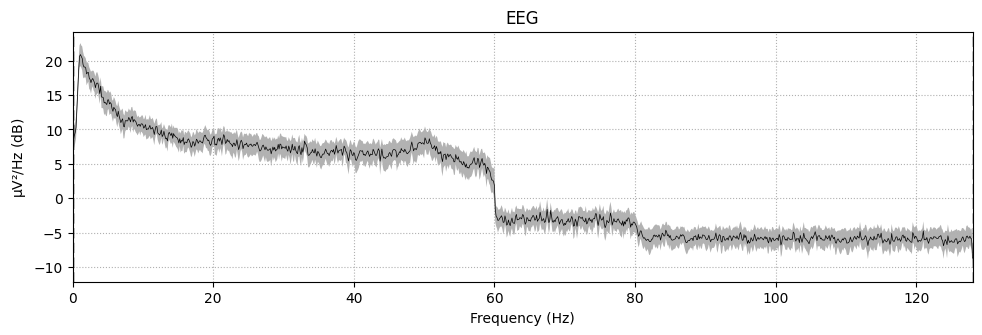

In [ ]:
spectrum = running_denoised_raw.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads");

In [ ]:
running_original_raw_filt = running_original_raw.copy().filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Effective window size : 8.000 (s)


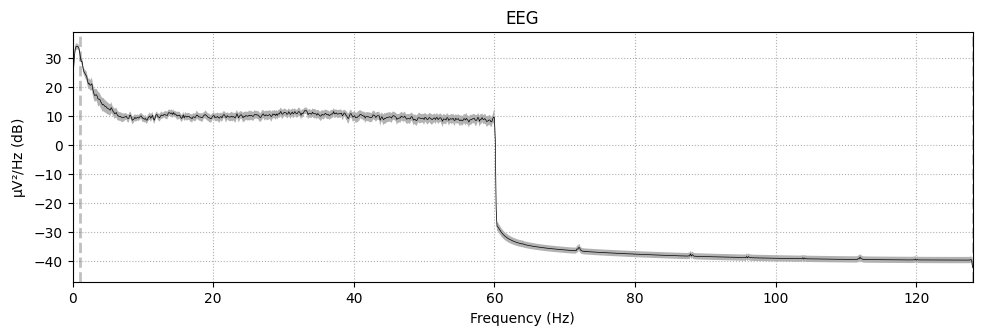

In [ ]:
spectrum = running_original_raw_filt.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads", );

## ICA

### Denoised

In [ ]:
ica = ICA(n_components=30, max_iter="auto", random_state=0)
ica.fit(running_original_raw_filt)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 24.4s.


<ipython-input-46-4a7e42c1f1c5>:2: RuntimeWarning: Using n_components=30 (resulting in n_components_=30) may lead to an unstable mixing matrix estimation because the ratio between the largest (24) and smallest (1.1e-31) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 28
  ica.fit(running_original_raw_filt)


<ICA | raw data decomposition, method: fastica (fit in 57 iterations on 260636 samples), 30 ICA components (30 PCA components available), channel types: eeg, no sources marked for exclusion>

In [ ]:
ica

<ICA | raw data decomposition, method: fastica (fit in 57 iterations on 260636 samples), 30 ICA components (30 PCA components available), channel types: eeg, no sources marked for exclusion>

In [ ]:
explained_var_ratio = ica.get_explained_variance_ratio(running_original_raw_filt)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of eeg variance explained by all components: 0.001030235480347752


In [ ]:
for i in range(30):
    explained_var_ratio = ica.get_explained_variance_ratio(
        running_original_raw_filt, components=[i], ch_type="eeg"
    )
    # This time, print as percentage.
    ratio_percent = round(100 * explained_var_ratio["eeg"], 6)
    print(
        f"Fraction of variance in EEG signal explained by {i} component: "
        f"{ratio_percent}%"
    )

Fraction of variance in EEG signal explained by 0 component: 0.019995%
Fraction of variance in EEG signal explained by 1 component: 0.015753%
Fraction of variance in EEG signal explained by 2 component: 0.011732%
Fraction of variance in EEG signal explained by 3 component: 0.009197%
Fraction of variance in EEG signal explained by 4 component: 0.00808%
Fraction of variance in EEG signal explained by 5 component: 0.007464%
Fraction of variance in EEG signal explained by 6 component: 0.007088%
Fraction of variance in EEG signal explained by 7 component: 0.004243%
Fraction of variance in EEG signal explained by 8 component: 0.002714%
Fraction of variance in EEG signal explained by 9 component: 0.002824%
Fraction of variance in EEG signal explained by 10 component: 0.002706%
Fraction of variance in EEG signal explained by 11 component: 0.001742%
Fraction of variance in EEG signal explained by 12 component: 0.00151%
Fraction of variance in EEG signal explained by 13 component: 0.001188%
Frac

Creating RawArray with float64 data, n_channels=30, n_times=260636
    Range : 0 ... 260635 =      0.000 ...  1018.105 secs
Ready.


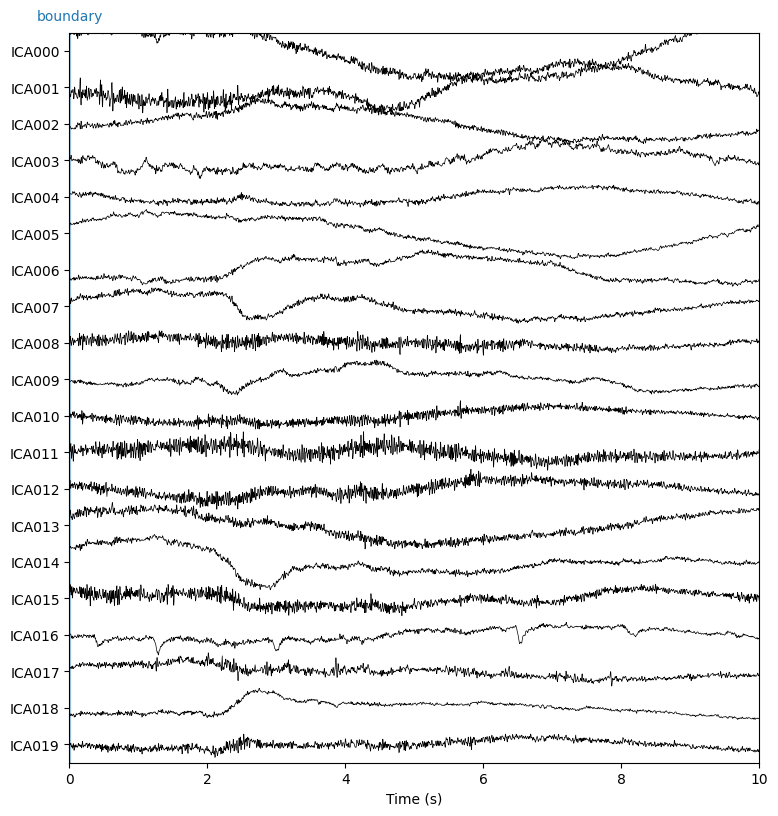

In [ ]:
ica.plot_sources(running_original_raw, show_scrollbars=False, stop=10);

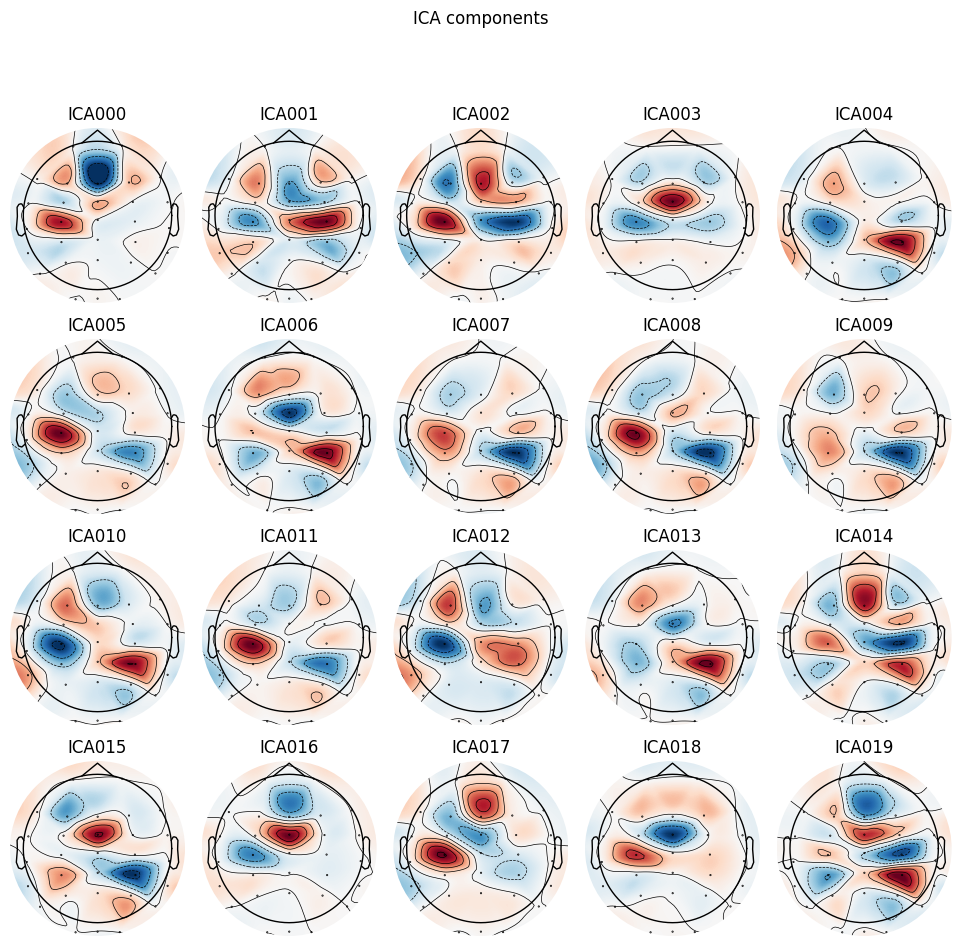

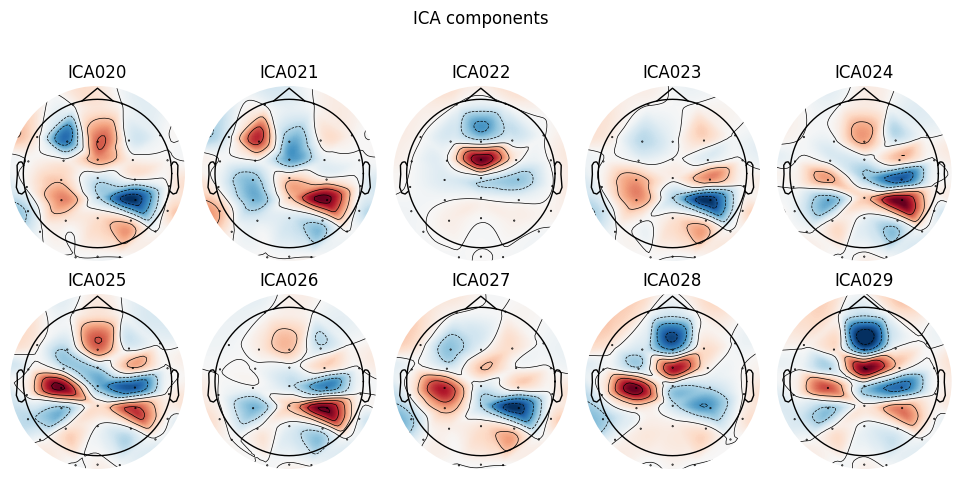

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [ ]:
ica.plot_components()

### Denoised

In [5]:
ica = ICA(n_components=30, max_iter="auto", random_state=0)
ica.fit(running_denoised_raw)

Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-5-b970e703c2b0>:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(running_denoised_raw)


Selecting by number: 30 components
Fitting ICA took 36.4s.


<ipython-input-5-b970e703c2b0>:2: RuntimeWarning: Using n_components=30 (resulting in n_components_=30) may lead to an unstable mixing matrix estimation because the ratio between the largest (18) and smallest (3.6e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 29
  ica.fit(running_denoised_raw)


<ICA | raw data decomposition, method: fastica (fit in 78 iterations on 260096 samples), 30 ICA components (30 PCA components available), channel types: eeg, no sources marked for exclusion>

Fraction of eeg variance explained by all components: 0.024945022740520684
Fraction of variance in EEG signal explained by 0 component: 0.378829%
Fraction of variance in EEG signal explained by 1 component: 0.290677%
Fraction of variance in EEG signal explained by 2 component: 0.263134%
Fraction of variance in EEG signal explained by 3 component: 0.244773%
Fraction of variance in EEG signal explained by 4 component: 0.17966%
Fraction of variance in EEG signal explained by 5 component: 0.152154%
Fraction of variance in EEG signal explained by 6 component: 0.169423%
Fraction of variance in EEG signal explained by 7 component: 0.157768%
Fraction of variance in EEG signal explained by 8 component: 0.142032%
Fraction of variance in EEG signal explained by 9 component: 0.138055%
Fraction of variance in EEG signal explained by 10 component: 0.125089%
Fraction of variance in EEG signal explained by 11 component: 0.115541%
Fraction of variance in EEG signal explained by 12 component: 0.098205%


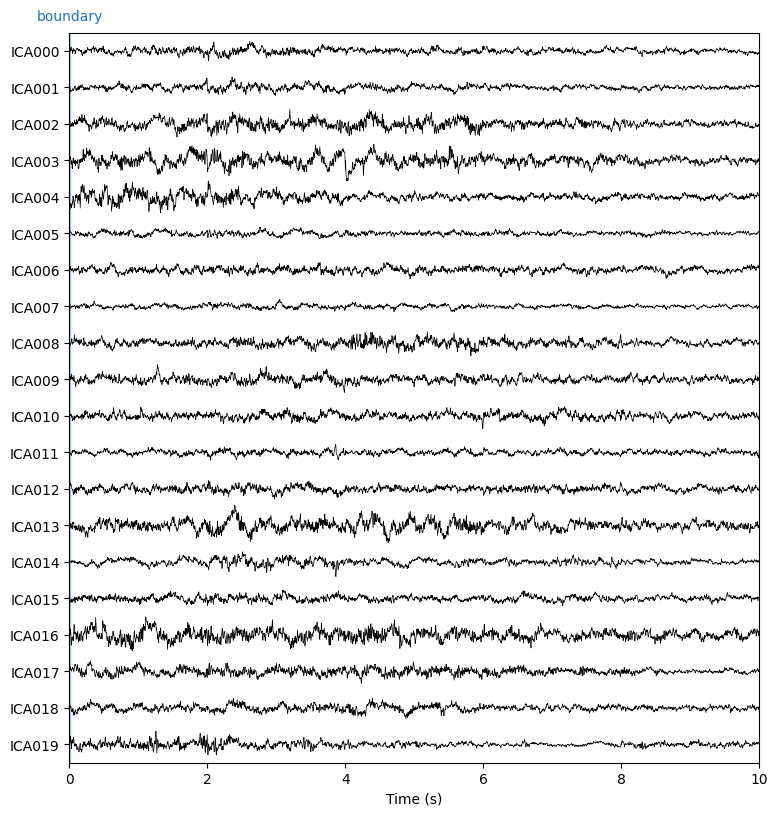

In [7]:
explained_var_ratio = ica.get_explained_variance_ratio(running_denoised_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

for i in range(30):
    explained_var_ratio = ica.get_explained_variance_ratio(
        running_denoised_raw, components=[i], ch_type="eeg"
    )
    # This time, print as percentage.
    ratio_percent = round(100 * explained_var_ratio["eeg"], 6)
    print(
        f"Fraction of variance in EEG signal explained by {i} component: "
        f"{ratio_percent}%"
    )

ica.plot_sources(running_denoised_raw, show_scrollbars=False, stop=10);

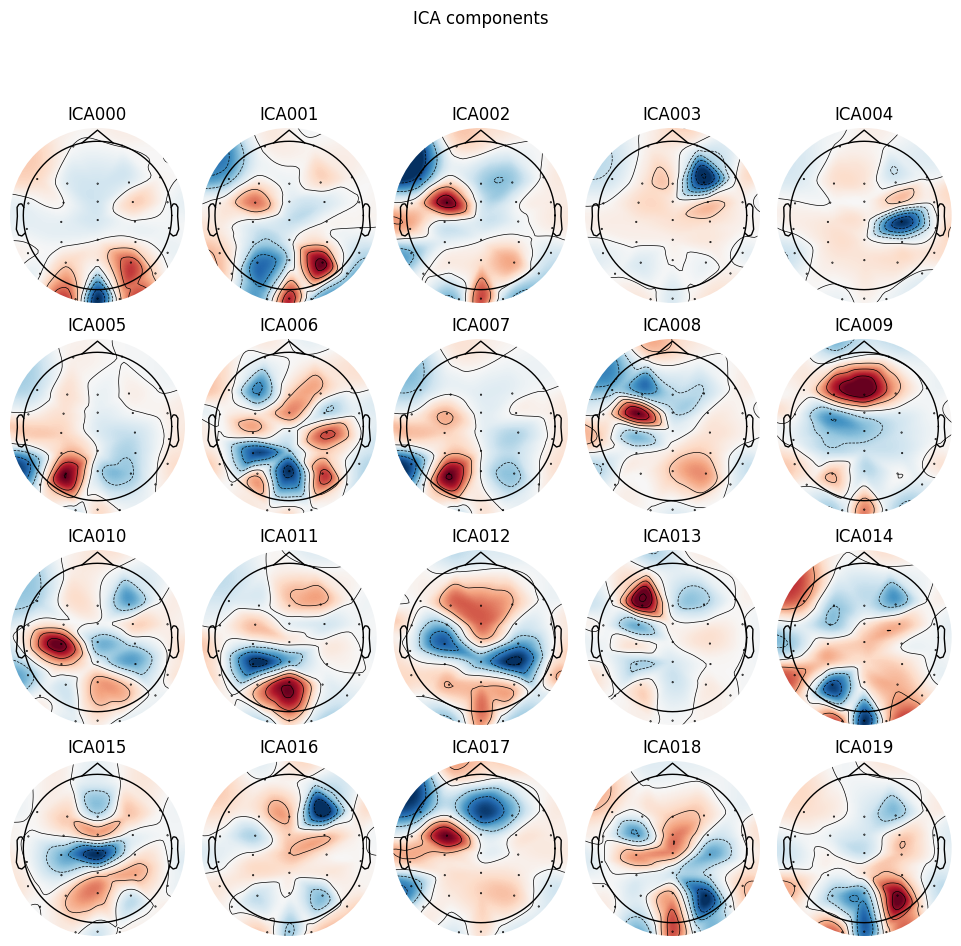

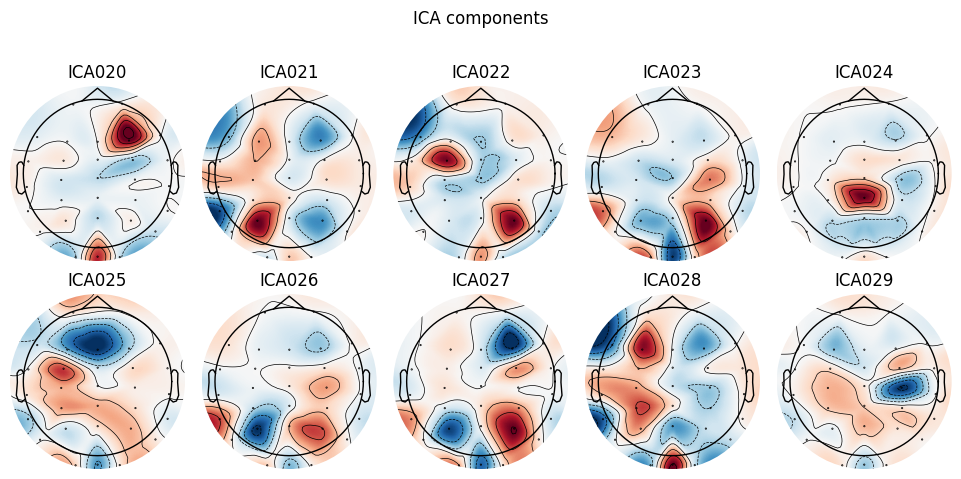

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [8]:
ica.plot_components()

# Sample data analysis

In [ ]:
from numpy import genfromtxt
sample = np.genfromtxt('AIEEG/sampledata/sampledata.csv', delimiter=',')
sample.shape

(30, 12568)

In [ ]:
sample.mean()

0.45943788506572286

In [ ]:
sample.std()

83.08003545524681

In [ ]:
sample.max()

503.02

In [ ]:
sample.min()

-435.11

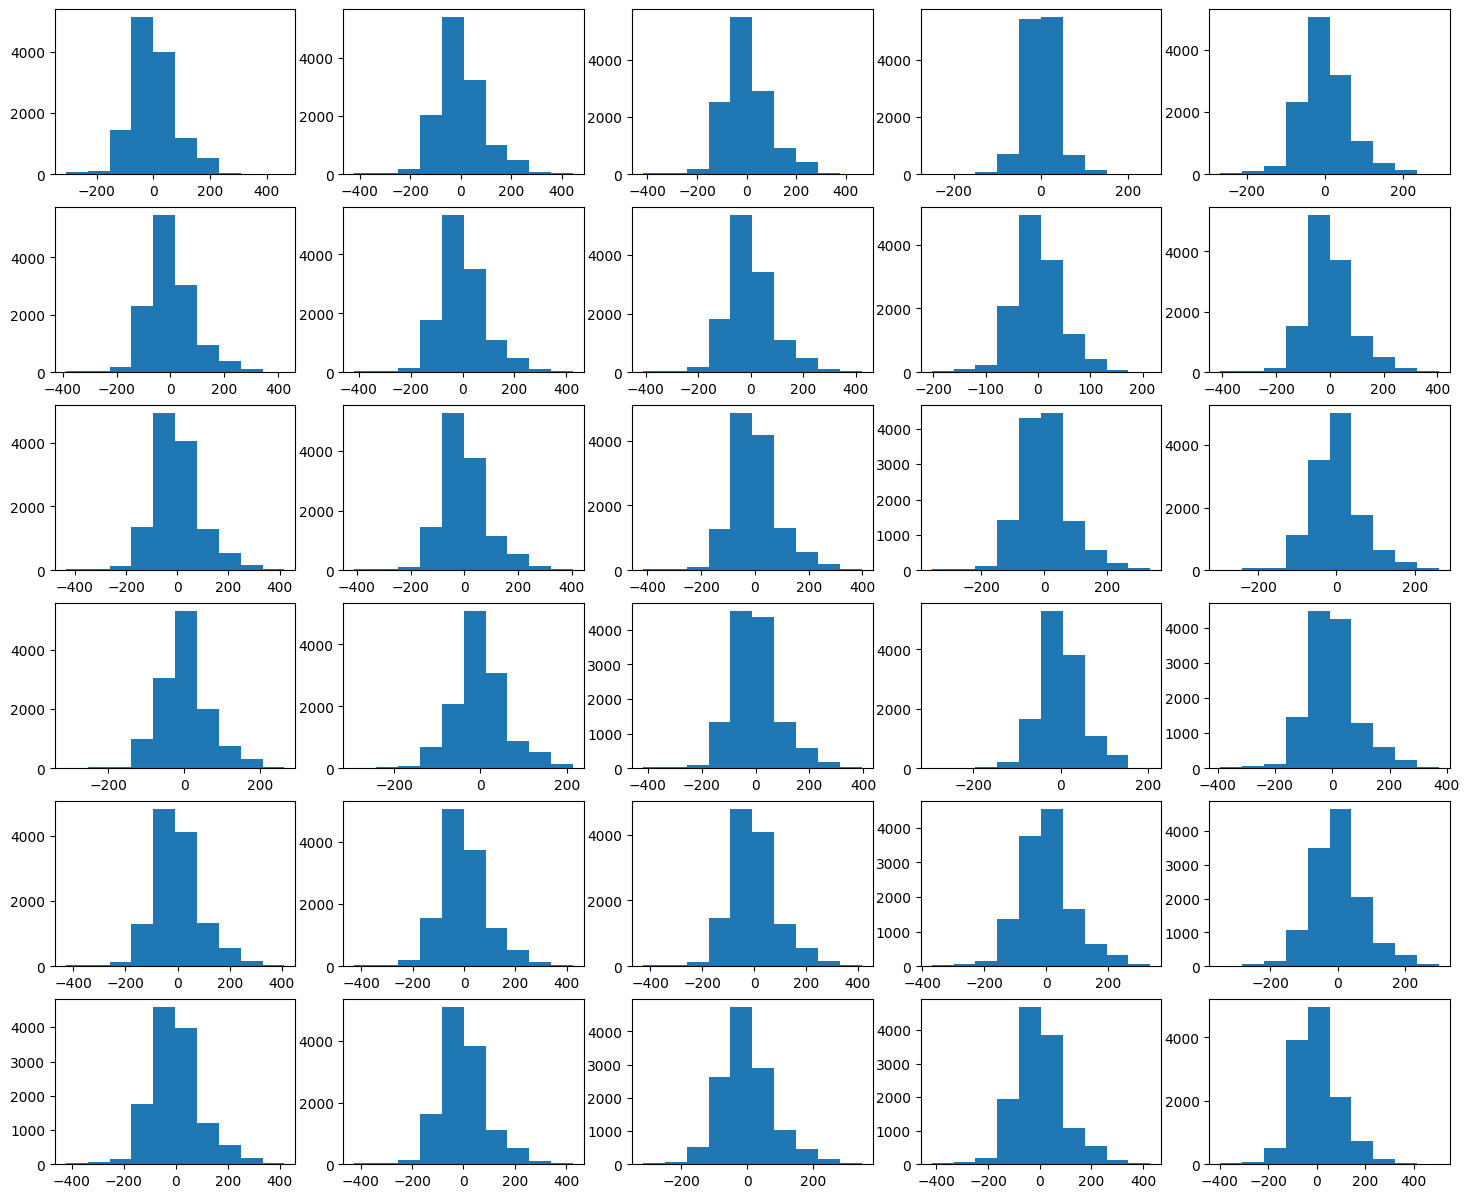

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(18, 15))
for channel, axis in zip(sample, ax.reshape(-1)):
    axis.hist(channel)

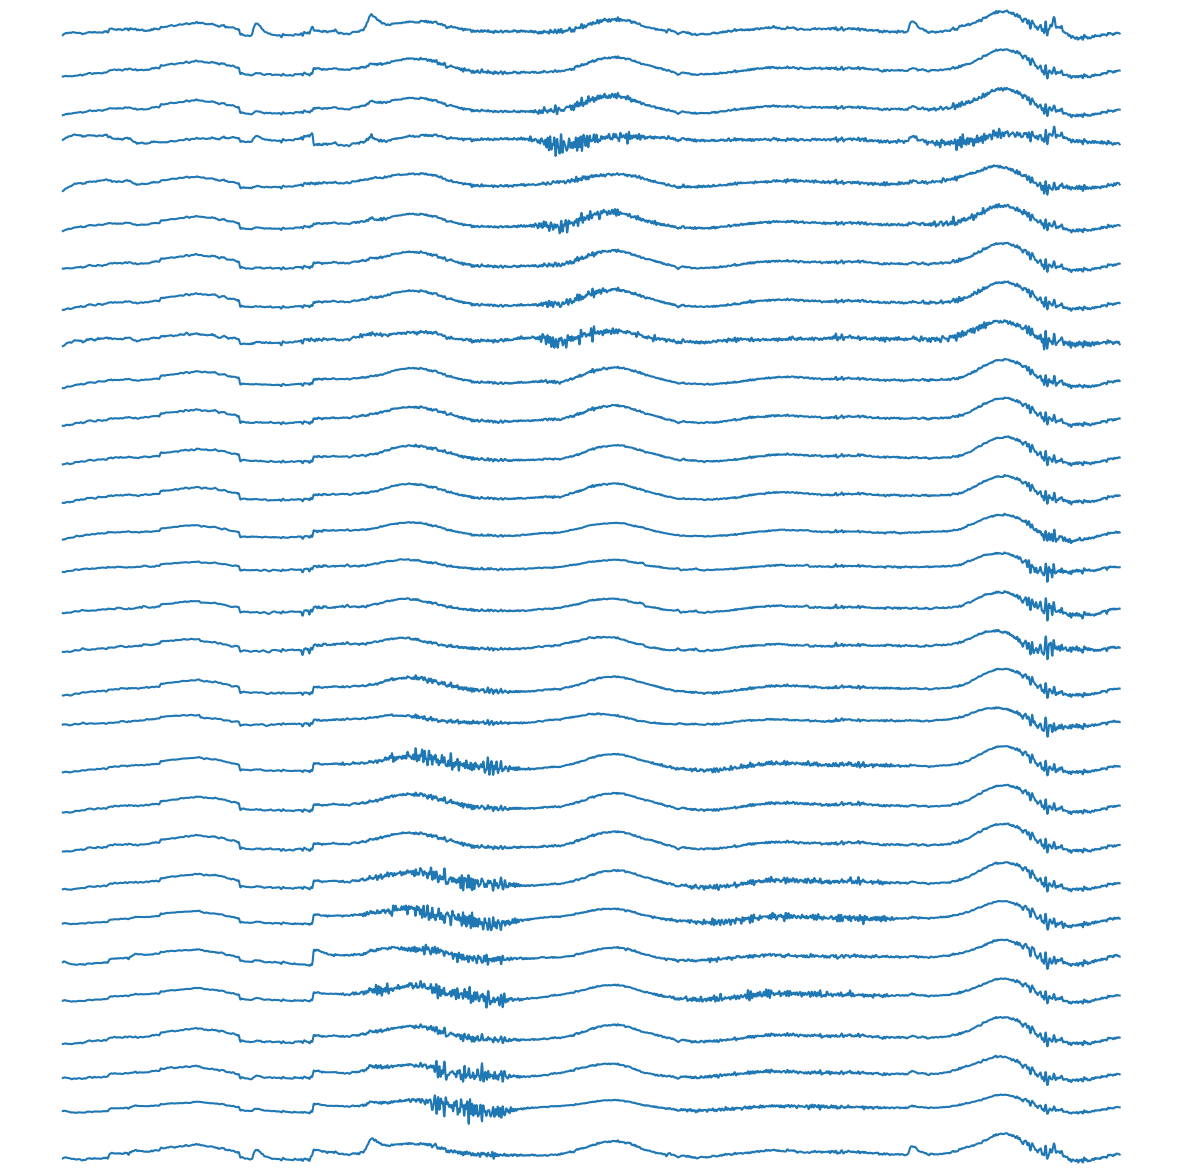

In [ ]:
t = 10
t_start = 10
fig, ax = plt.subplots(nrows=30, ncols=1, figsize=(15, 15))
for channel, axis in zip(sample, ax.reshape(-1)):
    axis.plot(channel[t_start*256:256*(t + t_start)])
    axis.set_axis_off()

## Try to run

In [ ]:
!cd AIEEG; python main.py

Reconstruct  ./sampledata/outputsample.csv  has been success  4.3730082511901855 sec(s)


In [ ]:
output = np.genfromtxt('AIEEG/sampledata/outputsample.csv', delimiter=',')
output.shape

(30, 12288)

In [ ]:
print(output.mean(), output.std(), output.min(), output.max())

0.750103474493483 11.546468696334104 -96.7159652709961 93.07881164550781


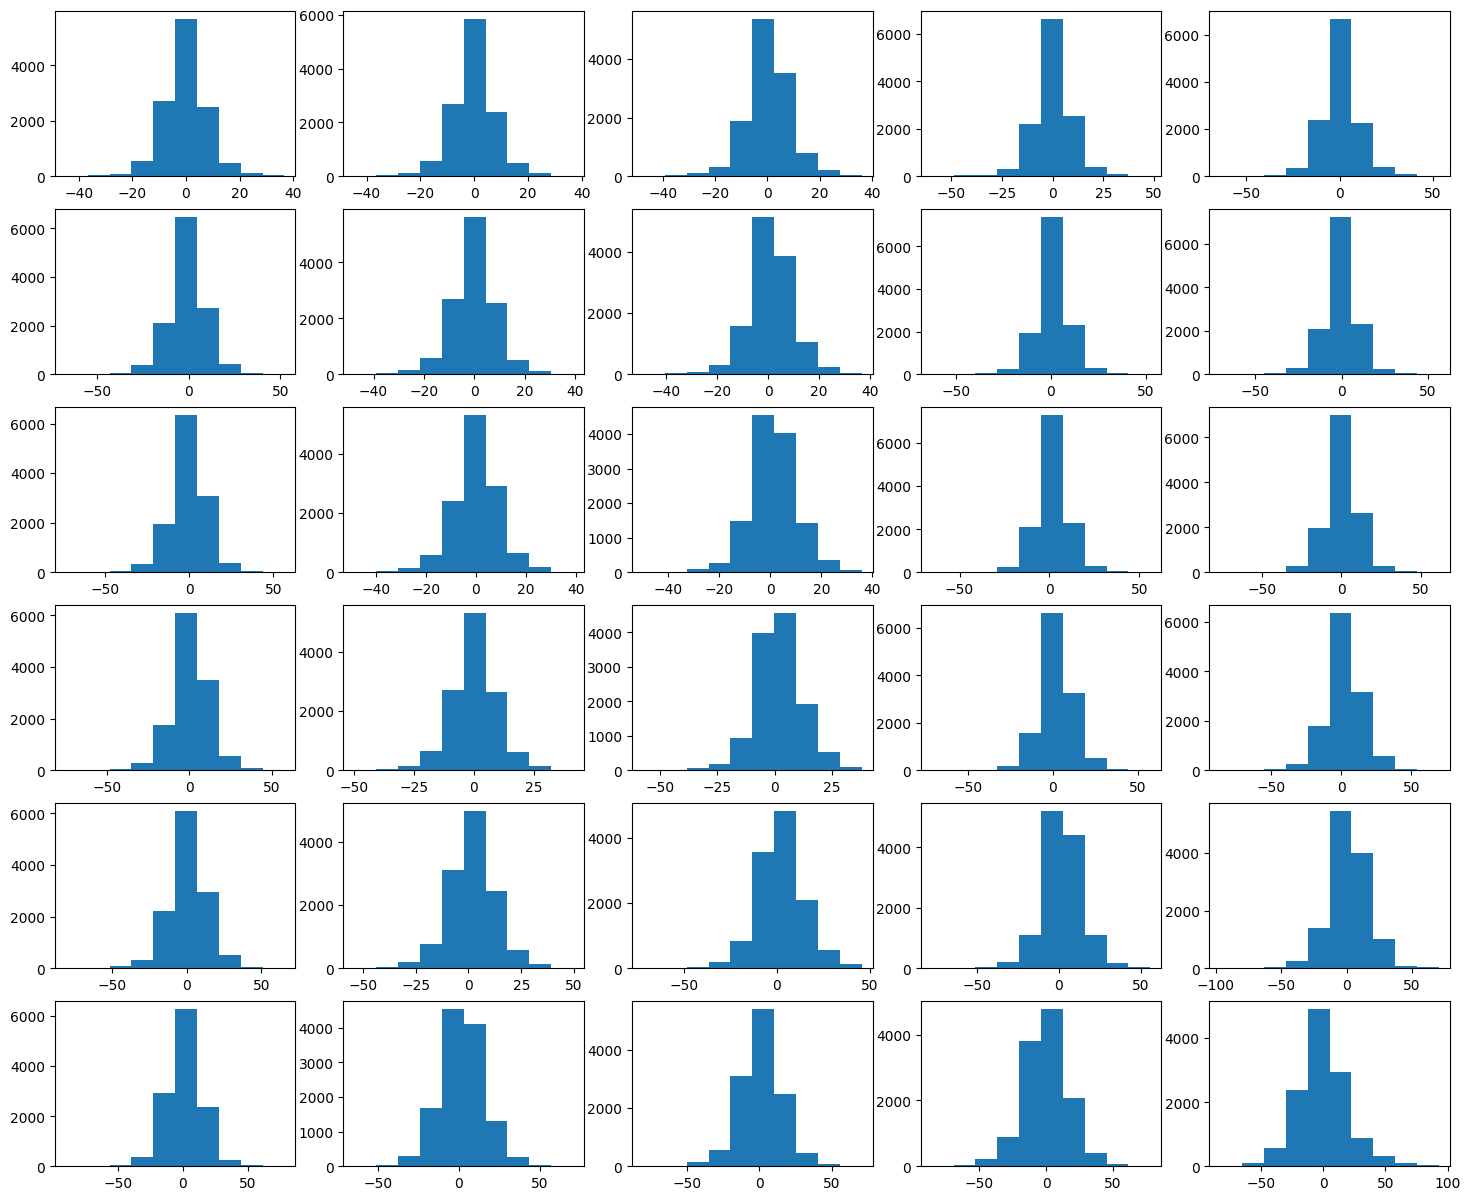

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(18, 15))
for channel, axis in zip(output, ax.reshape(-1)):
    axis.hist(channel)

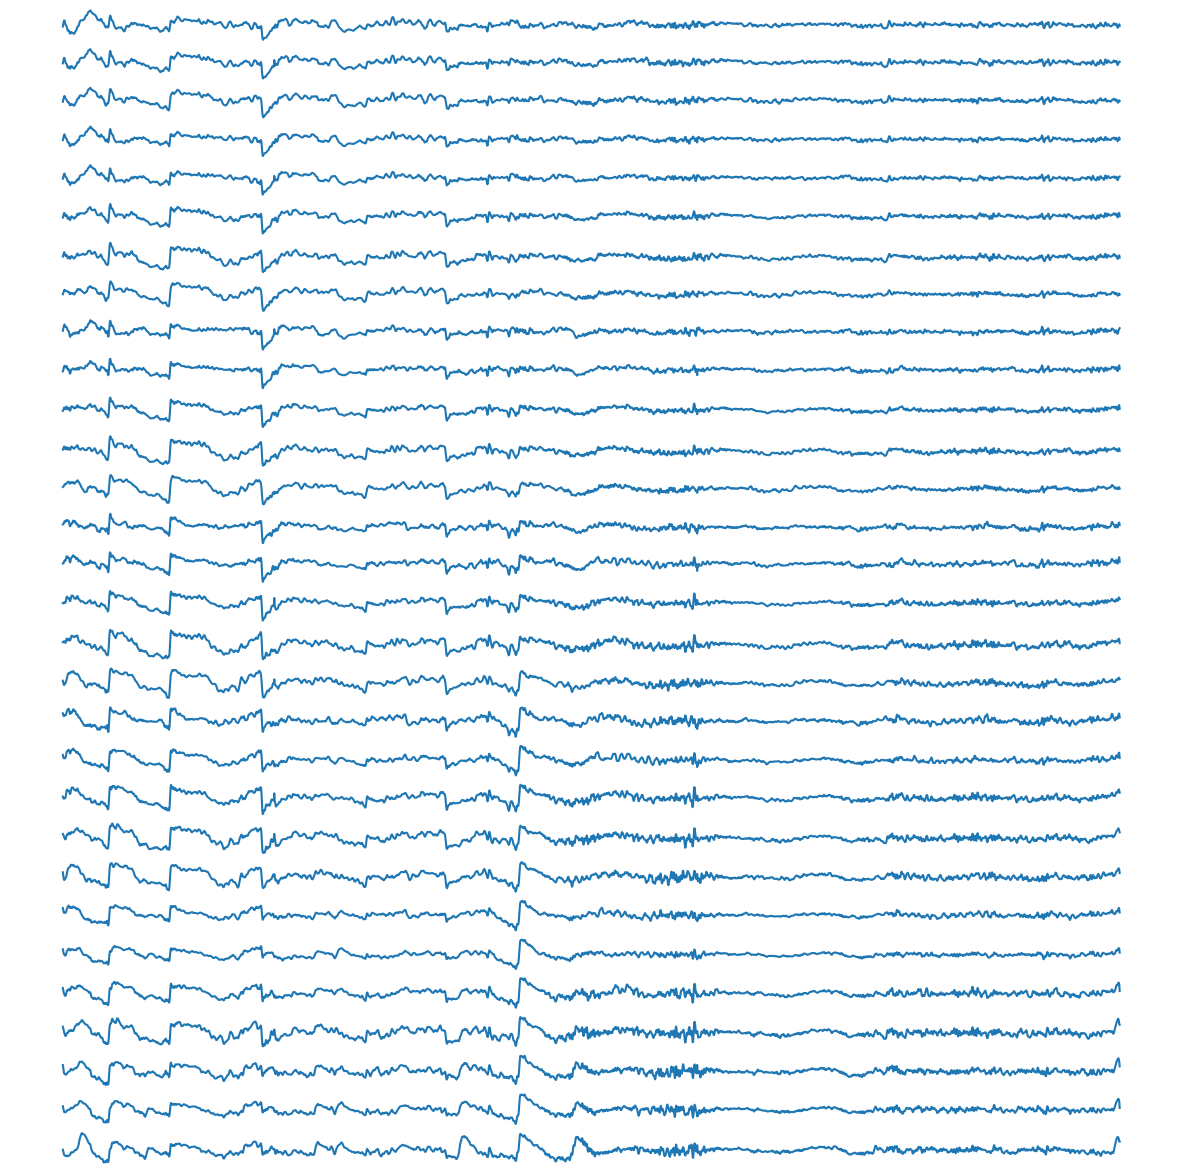

In [ ]:
t = 10
t_start = 10
fig, ax = plt.subplots(nrows=30, ncols=1, figsize=(15, 15))
for channel, axis in zip(output, ax.reshape(-1)):
    axis.plot(channel[t_start*256:256*(t + t_start)])
    axis.set_axis_off()

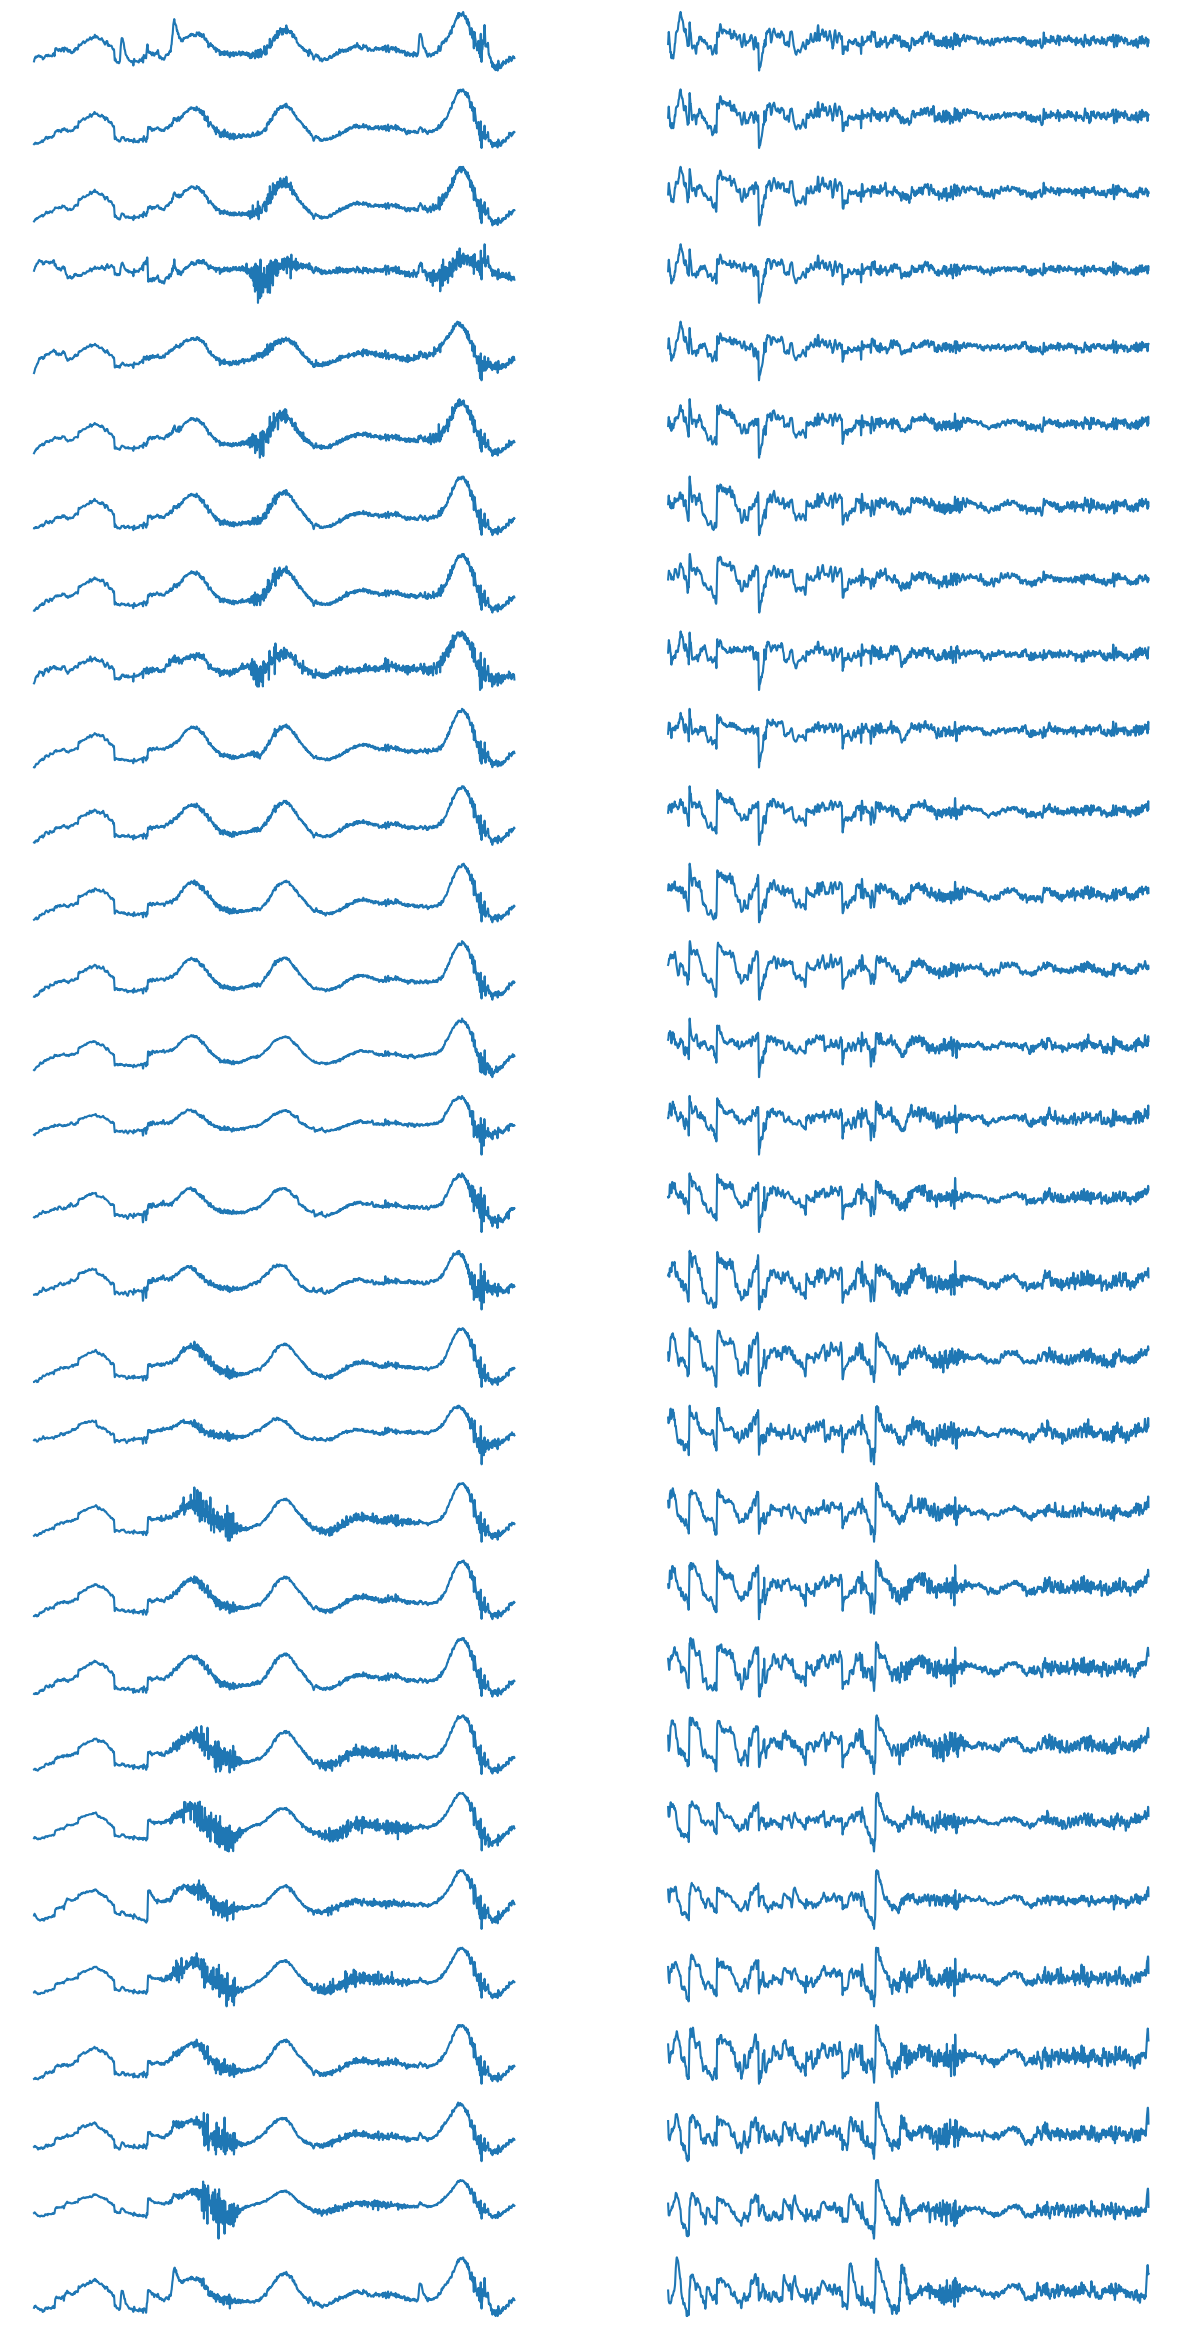

In [ ]:
t = 10
t_start = 10
fig, ax = plt.subplots(nrows=30, ncols=2, figsize=(15, 30))
for channel_s, channel_o, axis_s, axis_o in zip(sample, output, ax[:, 0], ax[:, 1]):
    axis_s.plot(channel_s[t_start*256:256*(t + t_start)])
    axis_s.set_axis_off()
    axis_o.plot(channel_o[t_start*256:256*(t + t_start)])
    axis_o.set_axis_off()